In [25]:
import os
os.chdir('/workspace')
print("当前工作目录:", os.getcwd())
import re
import matplotlib.pyplot as plt
import numpy as np

当前工作目录: /workspace


In [26]:
path = 'executables/bert/log_0716/fp16_batch1_2x16_torch/'
file_name = os.path.join(path,'gpu.info')
log_file = os.path.join(path,'train.log')
gpuid = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]
# gpuid = [14,15]

In [27]:
def parse_ixsmi_output(output):
    gpu_infos = {}
    lines = output.splitlines()
    current_gpu_id = None
    
    for line in lines:
        gpu_id_match = re.match(r'^\| (\d+)\s+', line)
        if gpu_id_match:
            current_gpu_id = int(gpu_id_match.group(1))
            gpu_infos[current_gpu_id] = {'memory_usage': 0, 'power_usage': None}
        
        if current_gpu_id is not None:
            memory_match = re.search(r'(\d+)MiB / \d+MiB', line)
            if memory_match:
                memory_usage = int(memory_match.group(1)) / 1024  # 转换为 GB
                gpu_infos[current_gpu_id]['memory_usage'] = memory_usage
            
            power_match = re.search(r'(\d+)W / \d+W', line)
            if power_match and "N/A" not in line:
                power_usage = int(power_match.group(1))
                gpu_infos[current_gpu_id]['power_usage'] = power_usage
    
    return gpu_infos

def parse_log(file_name):
    with open(file_name, 'r') as file:
        data = file.read()

    timestamps = re.findall(r'Timestamp\s+(.*?)\n', data)
    timestamp_blocks = data.split('Timestamp')[1:]

    steps = []
    for block in timestamp_blocks:
        gpu_infos = parse_ixsmi_output(block)
        steps.append(gpu_infos)

    return timestamps, steps

timestamps, steps = parse_log(file_name)

In [28]:
def calculate_statistics(steps,gpu_id=None):
    usages = []

    for step in steps:
        power_usage = [gpu['power_usage'] for id, gpu in step.items()
                        if id in gpu_id and
                        gpu['memory_usage'] > 0.2 and 
                        gpu['power_usage'] is not None]
        
        memory_usage = [gpu['memory_usage'] for id, gpu in step.items() 
                        if id in gpu_id and
                        gpu['memory_usage'] > 0.2]
        # print(power_usage)
        # print(memory_usage)
        if memory_usage:
            usages.append((np.mean(power_usage) if power_usage else 0, np.mean(memory_usage) if memory_usage else 0, np.max(memory_usage) if memory_usage else 0 ))
    return usages

usages = calculate_statistics(steps,gpu_id=gpuid)


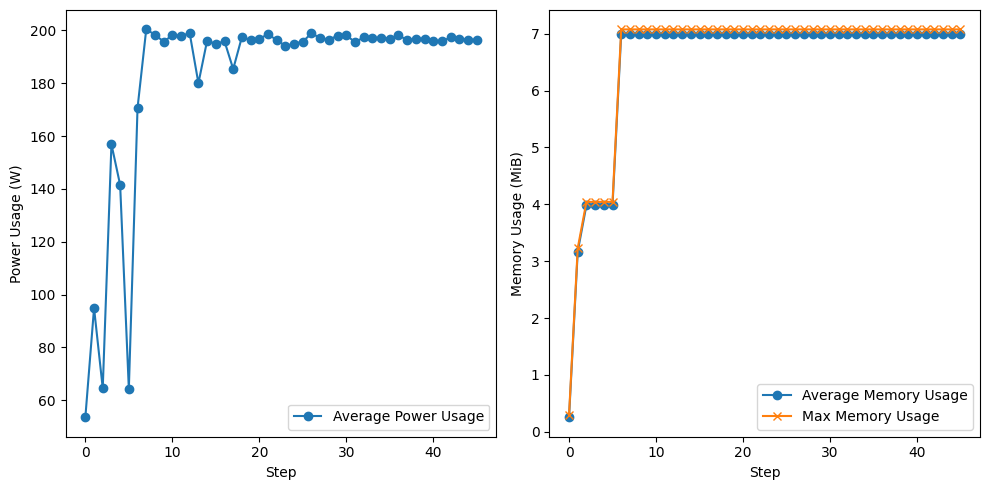

In [29]:
def plot_statistics(usages):
    steps = range(len(usages))
    avg_power = [x[0] for x in usages]
    avg_memory = [x[1] for x in usages]
    max_memory = [x[2] for x in usages]

    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(steps, avg_power, marker='o', label='Average Power Usage')
    plt.xlabel('Step')
    plt.ylabel('Power Usage (W)')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(steps, avg_memory, marker='o', label='Average Memory Usage')
    plt.plot(steps, max_memory, marker='x', label='Max Memory Usage')
    plt.xlabel('Step')
    plt.ylabel('Memory Usage (MiB)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()

def overall_statistics(usages):
    all_power = [x[0] for x in usages[10:-1]]
    all_memory = [x[1] for x in usages[10:-1]]
    all_max_memory = [x[2] for x in usages[10:-1]]

    avg_power = np.mean(all_power)
    avg_memory = np.mean(all_memory)
    max_memory = np.max(all_max_memory)

    return avg_power, avg_memory, max_memory

avg_power, avg_memory, max_memory = overall_statistics(usages)

plot_statistics(usages)

In [30]:
log_data = {
    "loss": [],
    "mlm_acc": [],
    "global_steps": [],
    "learning_rate": [],
    "avg_seq_per_s": [],
    "avg_step_per_s": [],
}

with open(log_file, 'r') as file:
    for line in file:
        if "FINISHED" in line:
            match = re.match(r'.*"init_time": (\d+\.\d+).*', line)
            if match:
                init_time = float(match.group(1))
                # print(init_time)
            else:
                print("init_time not found")            
        if 'STEP_END' in line:
            pattern = r'"loss": (.*?), "mlm_acc": (.*?), .*?"global_steps": (.*?), .*?"learning_rate": (.*?), .*?"avg_seq/s": (.*?), "avg_step/s": (.*?), .*?'
            match = re.search(pattern, line)
            # 提取匹配到的数据
            if match:
                log_data["loss"].append(float(match.group(1)))
                log_data["mlm_acc"].append(float(match.group(2)))
                log_data["global_steps"].append(int(match.group(3)))
                log_data["learning_rate"].append(float(match.group(4)))
                log_data["avg_seq_per_s"].append(float(match.group(5)))
                log_data["avg_step_per_s"].append(float(match.group(6)))
            else:
                print('No match found')

# print(log_data["avg_seq_per_s"])


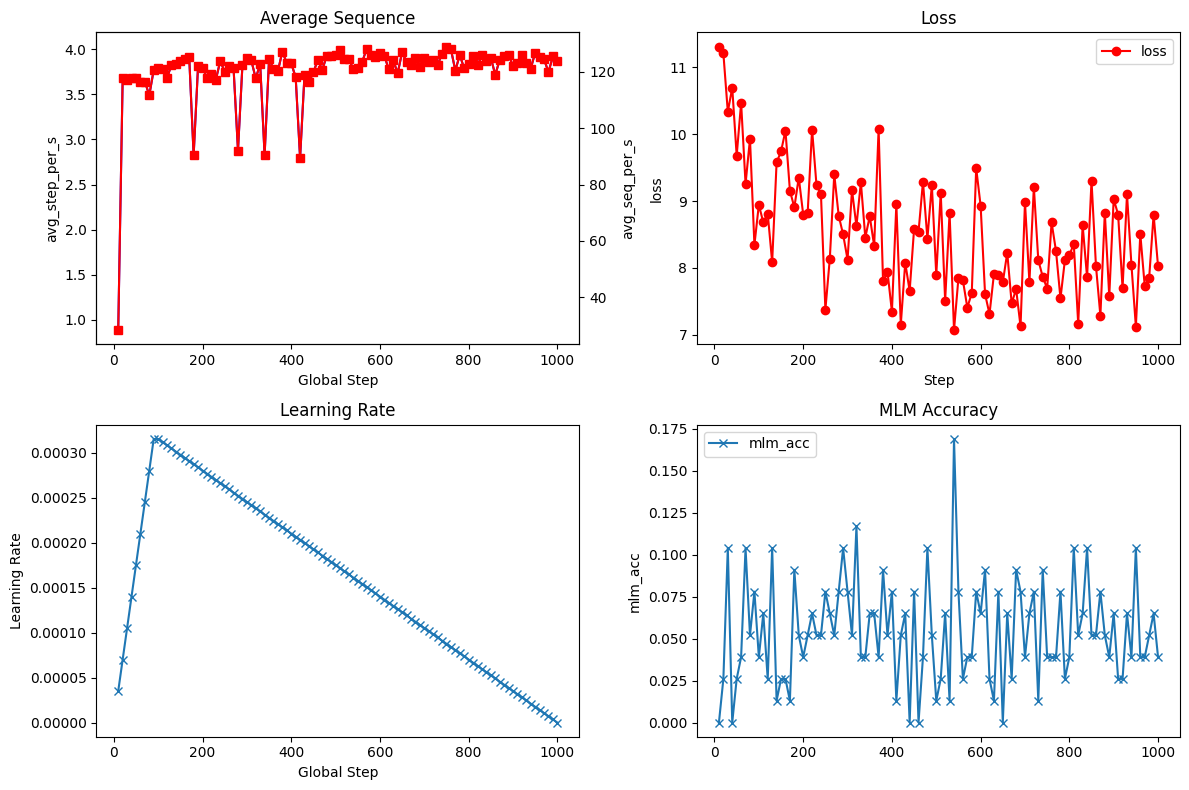

In [31]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(12, 8))

ax1.plot(log_data['global_steps'], log_data['avg_step_per_s'], 'b-', label='avg_step')
ax1.set_xlabel('Global Step')
ax1.set_ylabel('avg_step_per_s')

ax1_2 = ax1.twinx()  # 使用相同的 x 轴
ax1_2.plot(log_data['global_steps'], log_data['avg_seq_per_s'], 'r', label='avg_seq', marker='s')
ax1_2.set_ylabel('avg_seq_per_s')
ax1_2.set_title('Average Sequence')

# 第二个子图
# ax2 = plt.subplot(1, 2, 2)
ax2.plot(log_data['global_steps'], log_data['loss'], 'r',marker='o', label='loss')
ax2.set_xlabel('Step')
ax2.set_ylabel('loss')
ax2.legend(loc="upper right")
ax2.set_title('Loss')



# 第三个子图
ax3.plot(log_data['global_steps'], log_data['learning_rate'], marker='x', label='learning_rate')
ax3.set_xlabel('Global Step')
ax3.set_ylabel('Learning Rate')
ax3.set_title('Learning Rate')

# 隐藏第四个子图
ax4.plot(log_data['global_steps'], log_data['mlm_acc'], marker='x', label='mlm_acc')
ax4.set_ylabel('mlm_acc')
ax4.legend(loc="upper left")
ax4.set_title('MLM Accuracy')

# plt.subplots_adjust(wspace=1)  # 调整子图之间的间距
plt.tight_layout()

plt.show()

In [32]:
print(init_time)
print(f'Overall Average Power Usage: {avg_power} W')
print(f'Overall Average Memory Usage: {avg_memory} GB')
print(f'Overall Max Memory Usage: {max_memory} GB')

average_values = {}
for key, values in log_data.items():
    if key != "global_steps":
        # print(f'{key} : {values}')

        filtered_values = [v for i, v in enumerate(values) if log_data["global_steps"][i] > 10]
        if filtered_values:
            average_values[key] = sum(filtered_values) / len(filtered_values)
        else:
            average_values[key] = None


print(f'Average avg_seq: {average_values["avg_seq_per_s"]}')
print(f'Average avg_step: {average_values["avg_step_per_s"]}')

30.31
Overall Average Power Usage: 196.0392857142857 W
Overall Average Memory Usage: 7.0 GB
Overall Max Memory Usage: 7.07421875 GB
Average avg_seq: 121.32756861503236
Average avg_step: 3.7914865192197613
